In [1]:
%pylab inline
from pywavan import fbm2d
from pywavan import powspec
from pywavan import imsmooth
from pywavan import fan_trans
from pywavan import tauq
from pywavan import Dh
from pywavan import angluarPS
from astropy.io import fits
import itertools
from scipy.stats import linregress
from scipy import interpolate
from random import randint
from random import sample
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


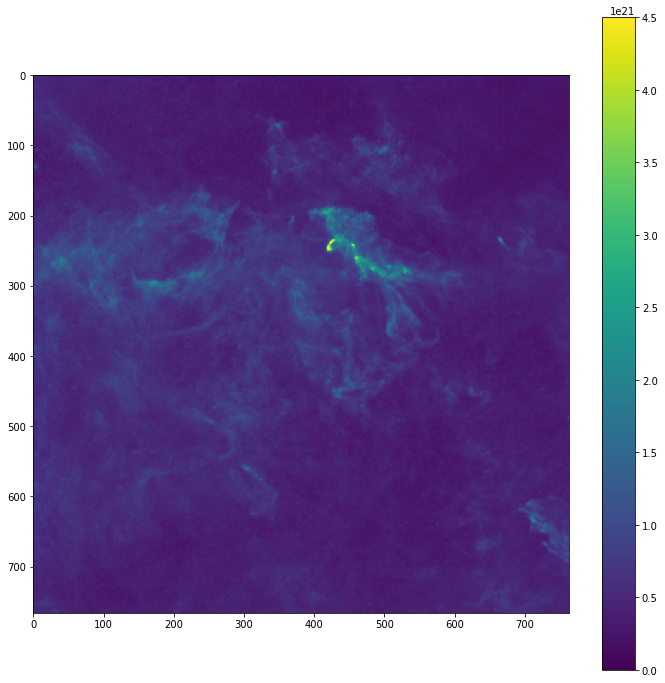

In [2]:
HDU = fits.open("HGBS_polaris_cdens_rot_rebin_cut.fits")

im = HDU[0].data

ny=im.shape[0]
nx=im.shape[1]

figure(figsize=(12,12))
imshow(im,vmin=0,vmax=4.5e21)
colorbar()

In [3]:
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=1, q=0, qdyn=False)
M=np.size(wav_k)
q=[]
q=[2.9]*M
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=1, q=q, qdyn=False)

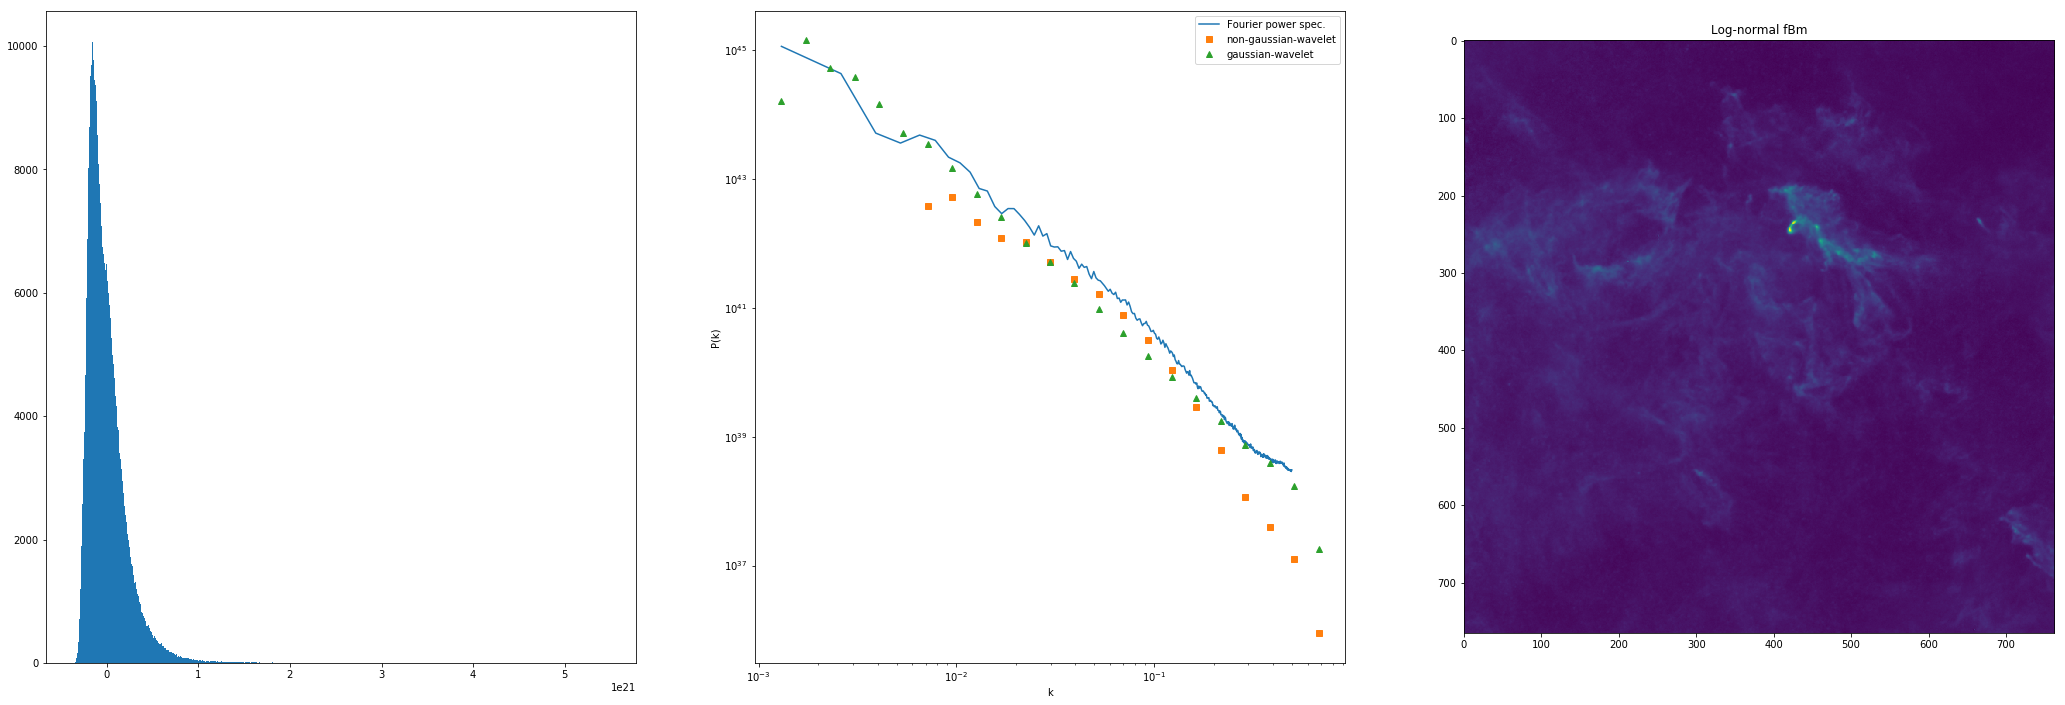

In [4]:
tab_k, spec_k = powspec(im, reso=1.)
merged = list(itertools.chain.from_iterable(im))

figure(figsize=(36,12))
plt.subplot(1,3,1)
plt.hist(merged,bins='auto', label='Observation')
plt.subplot(1,3,2)
plot(tab_k, spec_k, label='Fourier power spec.')
plot(wav_k, S1a[1,:], 's', label='non-gaussian-wavelet')
plot(wav_k, S1a[2,:], '^', label='gaussian-wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.subplot(1,3,3)
imshow(im)
plt.title('Log-normal fBm')
plt.show()


In [17]:
H=range(1,15)

tau, S1, wav_k, ab = tauq(im, H=H,q=q,kmaxscale=0.05,kminscale=0.3)

/nix/store/n86cvk7sl26ww2rpr4m7nfd6r15bdz3d-python3.6-matplotlib-3.0.3/lib/python3.6/site-packages/matplotlib/ticker.py:2210: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/nix/store/n86cvk7sl26ww2rpr4m7nfd6r15bdz3d-python3.6-matplotlib-3.0.3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: invalid value encountered in double_scalars
  coeff = np.round(x / b ** exponent)


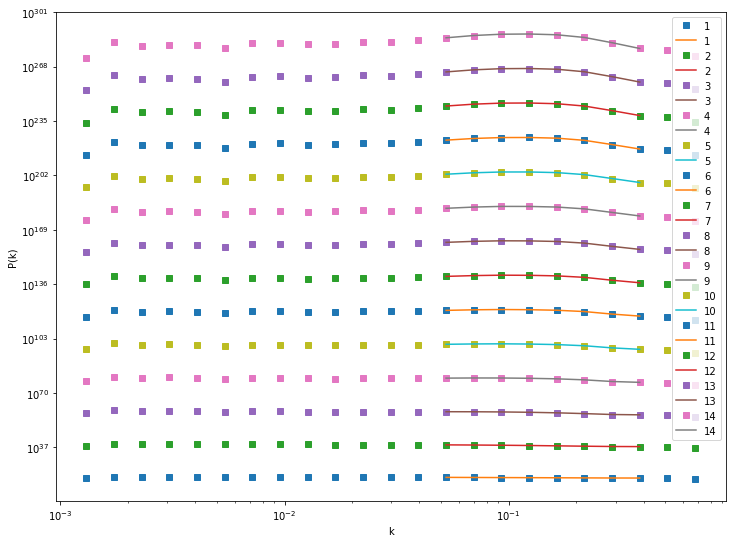

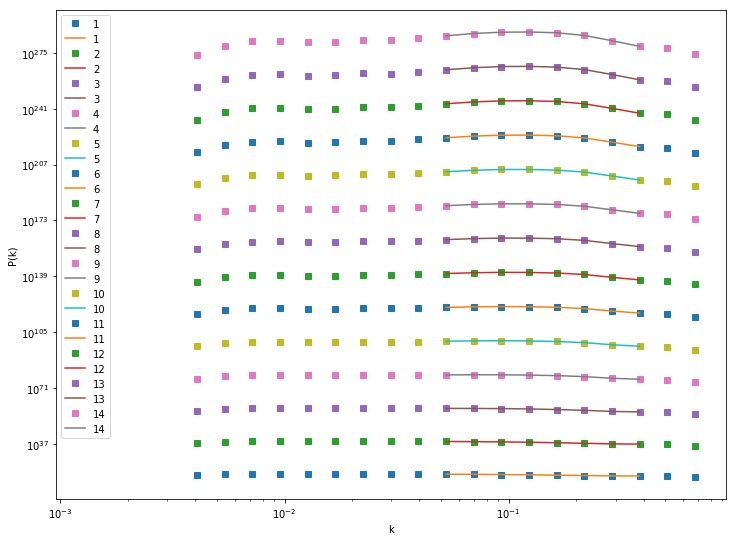

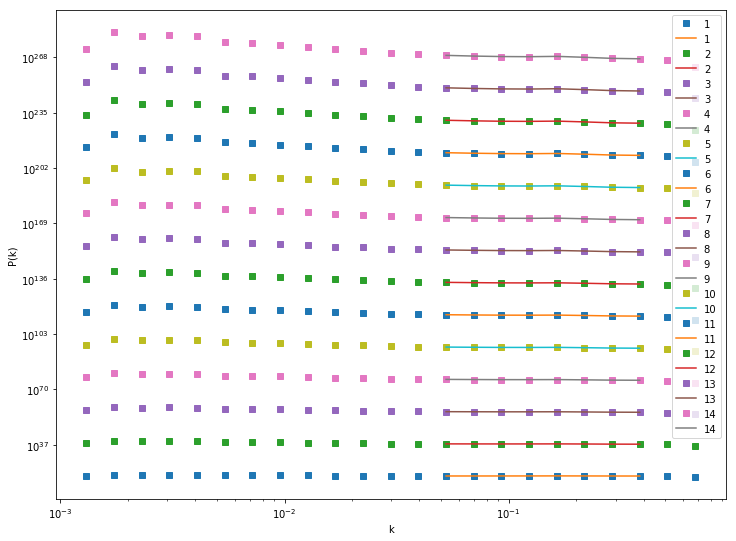

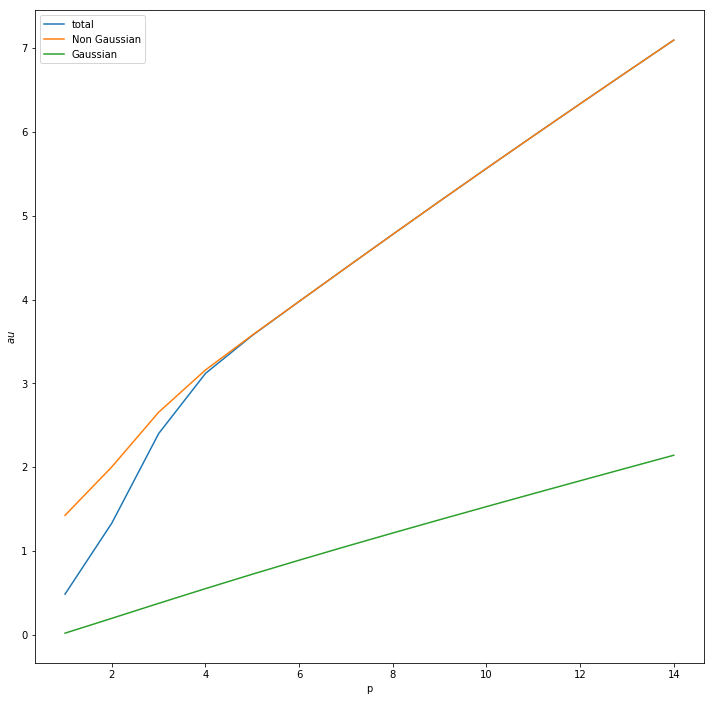

In [18]:
#Use this cell to plot if q!=0
figure(figsize=(12,9))

for i in range(0,np.size(H)):
    
    plot(wav_k, S1[0,i],'s', label=H[i])
    plot(wav_k[ab], S1[0,i,ab], label=H[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend()

figure(figsize=(12,9))

for i in range(0,np.size(H)):
    
    plot(wav_k, S1[1,i],'s', label=H[i])
    plot(wav_k[ab], S1[1,i,ab], label=H[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend()

figure(figsize=(12,9))
    
for i in range(0,np.size(H)):
    
    plot(wav_k, S1[2,i],'s', label=H[i])
    plot(wav_k[ab], S1[2,i,ab], label=H[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend()

figure(figsize=(12,12))
plot(H,-tau[0,:],label='total')
plot(H,-tau[1,:],label='Non Gaussian')
plot(H,-tau[2,:],label='Gaussian')
plt.xlabel('p')
plt.ylabel('$\tau$')
plt.legend()

In [3]:
#Seprating the scales and the angles.
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=1, zeromean=False, q=0 , qdyn=True, skewl=0.4, pownorm=False, angular=True)

In [4]:
N=wt.shape[1] #Number of angles
M=wt.shape[0] #number of scales

In [14]:
#This cell removes the results of the previous cell.
#Instead of setting the nan pixels equal to zero an interpolation is done.

#wt_inv=np.zeros((M,N,ny,nx),dtype=numpy.complex) 

im_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse mpv. image

fbm_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse fbm. image

l=np.zeros((N,ny,nx),dtype=numpy.bool) #Logical matrix to check for the nan values of log(mpv_ang_inv[j,:,:])

t=np.zeros((ny,nx)) #A temp to set the nan values to zero 

grid_x, grid_y = np.mgrid[0:765:766j,0:762:763j]

mean=np.ones(N)*np.mean(im)/11

mean[0]=mean[0]+0.45*10**20
mean[1]=mean[1]+0.3*10**20
mean[2]=mean[2]+0.3*10**20
mean[3]=mean[3]+0.4*10**20
mean[4]=mean[4]+0.1*10**20
mean[5]=mean[5]+0.01*10**20
mean[6]=mean[6]-0.2*10**20
mean[7]=mean[7]-0.2*10**20
mean[8]=mean[8]-0.1*10**20
mean[9]=mean[9]-0.1*10**20
mean[10]=mean[10]-0.2*10**20

for j in range(N):
    
    im_ang_inv[j,:,:]=np.sum(wt[:,j,:,:].real,axis=0) #The mpv. image for this specific angle
    
    #--------------------------------------------------------------#
    im_ang_inv[j,:,:]=im_ang_inv[j,:,:]-np.mean(im_ang_inv[j,:,:])+mean[j]  # #######  Guessing the mean #########
    #--------------------------------------------------------------#
    im_ang_inv[j,:,:]=im_ang_inv[j,:,:]/np.std(im_ang_inv[j,:,:])
    #im_ang_inv[j,:,:]=np.abs(im_ang_inv[j,:,:]) #An attempt to remove the negative values by abs
    im_ang_inv[j,:,:]=np.abs(im_ang_inv[j,:,:])
    
    #mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]/np.std(mpv_a#ng_inv[j,:,:])*np.std(mpv_ang[j,:,:])
    
    fbm_ang_inv[j,:,:]=log(im_ang_inv[j,:,:]) #The fbm. image for this specific angle
    
    
    #Setting up the points used for the interpolation.
    l[j,:,:]=np.isnan(fbm_ang_inv[j,:,:])
    x=grid_x[~l[j,:,:]] #All the non negative points.
    y=grid_y[~l[j,:,:]] #All the non negative points.
    
    values=fbm_ang_inv[j,~l[j,:,:]]  #Values of the function at the non-negative points. 
    
    inter=np.int(np.size(x)/1) #Number of points used in the interpolation.
    
    #Reducing the nuber of points used in the interpolation
    temp=sample(range(0,np.size(x)),inter) #Using a subset of the non-negative points
    x=x[temp] 
    y=y[temp]
    values=values[temp]
    
    #Interpolation
    points=[x,y]
    points=np.transpose(points)
    
    fbm_ang_inv[j,:,:] = griddata(points, values, (grid_x, grid_y), method='nearest')
    
    #Separation the scales of each angle.
    #wt_mpv_inv[:,j,:,:], S11a, wav_k, S1a, q = fan_trans(t, zeromean=False, reso=1, q=0 , qdyn=True, skewl=0.4, pownorm=False)    
    

In [ ]:
#Plotting the results of the inversion process
for j in range(N):
    
    hist_im_ang_inv = list(itertools.chain.from_iterable(im_ang_inv[j,:,:]))
    hist_fbm_ang_inv = list(itertools.chain.from_iterable(fbm_ang_inv[j,:,:]))
        
    
    figure(figsize=(36,12))
    plt.subplot(1,4,1)
    imshow(im_ang_inv[j,:,:])
    #plt.plot(points[:,0], points[:,1], 'k.', ms=1)
    colorbar()
    plt.title('Before log')
    plt.subplot(1,4,2)
    imshow(fbm_ang_inv[j,:,:])
    colorbar()
    plt.title('After log')

    plt.subplot(1,4,3)
    #plt.hist(hist_mpv_ang,bins='auto', label='Original mpv.model')
    plot(np.zeros(5),np.linspace(0,12000,5))
    plt.hist(hist_im_ang_inv,bins='auto', label='Inversion process')
    plt.legend()
    plt.title('Histogram of mpv. model')
    plt.subplot(1,4,4)
    plt.hist(hist_fbm_ang_inv,bins='auto', label='Inversion process')
    plt.legend()
    plt.title('Histogram of fbm. model')
    #plt.savefig('angle_inverse_linear.png')

In [ ]:
#The reconstructed homogenous image.
fbm_inv=np.sum(fbm_ang_inv,axis=0)

figure(figsize=(24,12))
plt.subplot(1,2,1)
imshow(fbm_inv)
colorbar()
plt.title('Homogenous image')
plt.subplot(1,2,2)
imshow(im)
colorbar()
plt.title('Original image')

#Calculating the removed part of the image (Nan part)
n=l*1
n=np.sum(n,axis=0)

figure(figsize=(12,12))
imshow(n)
colorbar()
plt.title('Nan part of the reconstructed fBm')
plt.show()